In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import jax
jax.config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import numpy.random as npr
from networks.dense import DenseNet
from networks.encoders import SigmaEncoder
from networks.decoders import SigmaDecoder
from models.SVAE_GMM import SVAE_GMM
from functools import partial
import flax.linen as nn
from networks.layers import LayerNorm
from tensorflow_probability.substrates.jax import distributions as tfd
import optax 
from train_utils import load_state, save_state, train_step, eval_step, create_dual_train_state, create_train_state

Let's start by generating a toy data set, as seen in [the original SVAE paper](https://proceedings.neurips.cc/paper/2016/file/7d6044e95a16761171b130dcb476a43e-Paper.pdf). The data-generating code is taken from [their repository](https://github.com/mattjj/svae).

In [2]:
#Loading MNIST
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

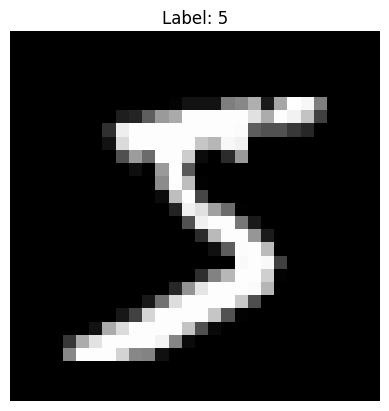

In [4]:
import matplotlib.pyplot as plt
flattened_img, label = train_dataset[0]

img_reshaped = flattened_img.view(28, 28)

plt.imshow(img_reshaped, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [5]:
cfg = lambda:0

# network hyperparameters
cfg.latent_D = 10
cfg.K = 20
cfg.encoder_stage_sizes = [1, 1, 1]
cfg.encoder_hidden_sizes = [500, 500, 2000]
cfg.decoder_stage_sizes = [1, 1, 1]
cfg.decoder_hidden_sizes = [2000, 500, 500]

# Define networks
encoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.encoder_stage_sizes, 
                          hidden_sizes=cfg.encoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)

decoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.decoder_stage_sizes, 
                          hidden_sizes=cfg.decoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)
                          
encoder = partial(SigmaEncoder, network_cls=encoder_network)
decoder = partial(SigmaDecoder, network_cls=decoder_network, likelihood=tfd.Normal)

# Creat model
model_builder = partial(SVAE_GMM, latent_D= cfg.latent_D, K = cfg.K, 
                        input_D = 784, encoder_cls=encoder, decoder_cls=decoder)

# Set optimization hyperparameters
cfg.lr_net = 1e-4
cfg.lr_pgm = 1e-3
#cfg.lr_decay_steps = 30000
#cfg.lr_final_mult = 0.01
cfg.learning_alg_pgm = 'sgd'
cfg.learning_alg_net = 'adam'
cfg.init_rng = jax.random.PRNGKey(47)
cfg.epochs = 1000

#net_schedule = optax.cosine_decay_schedule(cfg.lr_net, cfg.lr_decay_steps, cfg.lr_final_mult)
#pgm_schedule = optax.cosine_decay_schedule(cfg.lr_pgm, cfg.lr_decay_steps, cfg.lr_final_mult)
net_schedule = cfg.lr_net
pgm_schedule = cfg.lr_pgm
model, state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, model_builder, (1,784), learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

... and the warmup model's architecture. Just as in the SLDS, we will pre-train with a VAE to get latent codes which contain *some* semantic information about the data before we start clustering. Training the SVAE-GMM from scratch has a much higher chance of collapsing to a small number of states.

In [6]:
#Setting Up VAE W/O GMM Prior
from models.VAE import VAE
from train_utils import create_train_state 

warmup_model_builder = partial(VAE, latent_D=cfg.latent_D, input_D=784,
                               encoder_cls=encoder, decoder_cls=decoder)
warmup_model, warmup_state = create_train_state(cfg.init_rng, cfg.lr_net, warmup_model_builder, (1,784))

In [7]:
#Beta Annealing
def get_beta_with_warmup(current_step):
    min_beta = 0.001
    warmup_steps = 5000
    total_annealing_steps = 14000
    
    if current_step < warmup_steps:
        return min_beta
    else:
        annealing_step = current_step - warmup_steps
        return min_beta + (1.0 - min_beta) * min(1.0, annealing_step / total_annealing_steps)

In [8]:
#Pre-Training
from tqdm import tqdm

num_epochs = 50

losses = []
total_steps = 0


for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    epoch_losses = []

    for batch in pbar:
        total_steps += 1

        batch = batch[0]

        batch_np = batch.detach().cpu().numpy()

        warmup_state, metrics = train_step(warmup_state, batch_np, N_data=len(train_loader.dataset), local_kl_weight=1e-3)

        epoch_losses.append(metrics['loss'])
        
        if np.isnan(metrics['loss'].item()):
            break
    
    loss = np.mean(epoch_losses)
    losses.append(loss)
    print(f"Epoch {epoch+1} | Epoch Loss: {loss:.4f}")

Epoch 1: 100%|██████████| 469/469 [00:33<00:00, 14.05it/s]


Epoch 1 | Epoch Loss: 1208.0594


Epoch 2: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]


Epoch 2 | Epoch Loss: 1212.1848


Epoch 3: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]


Epoch 3 | Epoch Loss: 1198.1615


Epoch 4: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Epoch 4 | Epoch Loss: 1189.3925


Epoch 5: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]


Epoch 5 | Epoch Loss: 1184.0311


Epoch 6: 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Epoch 6 | Epoch Loss: 1174.8679


Epoch 7: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]


Epoch 7 | Epoch Loss: 1164.0419


Epoch 8: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]


Epoch 8 | Epoch Loss: 1151.0608


Epoch 9: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]


Epoch 9 | Epoch Loss: 1138.0077


Epoch 10: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]


Epoch 10 | Epoch Loss: 1123.2942


Epoch 11: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Epoch 11 | Epoch Loss: 1109.4871


Epoch 12: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]


Epoch 12 | Epoch Loss: 1093.9534


Epoch 13: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]


Epoch 13 | Epoch Loss: 1076.8525


Epoch 14: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 14 | Epoch Loss: 1061.0817


Epoch 15: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Epoch 15 | Epoch Loss: 1046.1338


Epoch 16: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]


Epoch 16 | Epoch Loss: 1029.1174


Epoch 17: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Epoch 17 | Epoch Loss: 1012.1582


Epoch 18: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]


Epoch 18 | Epoch Loss: 995.6655


Epoch 19: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]


Epoch 19 | Epoch Loss: 978.0220


Epoch 20: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


Epoch 20 | Epoch Loss: 960.1946


Epoch 21: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


Epoch 21 | Epoch Loss: 943.1990


Epoch 22: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]


Epoch 22 | Epoch Loss: 926.0982


Epoch 23: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Epoch 23 | Epoch Loss: 907.7218


Epoch 24: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]


Epoch 24 | Epoch Loss: 889.6829


Epoch 25: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]


Epoch 25 | Epoch Loss: 872.0989


Epoch 26: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 26 | Epoch Loss: 854.1340


Epoch 27: 100%|██████████| 469/469 [00:34<00:00, 13.52it/s]


Epoch 27 | Epoch Loss: 836.7115


Epoch 28: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 28 | Epoch Loss: 818.9687


Epoch 29: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 29 | Epoch Loss: 800.5055


Epoch 30: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]


Epoch 30 | Epoch Loss: 783.5916


Epoch 31: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Epoch 31 | Epoch Loss: 765.1679


Epoch 32: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Epoch 32 | Epoch Loss: 748.0625


Epoch 33: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]


Epoch 33 | Epoch Loss: 729.8397


Epoch 34: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]


Epoch 34 | Epoch Loss: 712.0472


Epoch 35: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]


Epoch 35 | Epoch Loss: 696.2323


Epoch 36: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]


Epoch 36 | Epoch Loss: 677.4631


Epoch 37: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]


Epoch 37 | Epoch Loss: 660.5627


Epoch 38: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 38 | Epoch Loss: 644.4648


Epoch 39: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Epoch 39 | Epoch Loss: 628.1035


Epoch 40: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]


Epoch 40 | Epoch Loss: 612.4303


Epoch 41: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]


Epoch 41 | Epoch Loss: 596.0005


Epoch 42: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]


Epoch 42 | Epoch Loss: 580.5034


Epoch 43: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]


Epoch 43 | Epoch Loss: 561.9405


Epoch 44: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]


Epoch 44 | Epoch Loss: 547.4763


Epoch 45: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Epoch 45 | Epoch Loss: 533.6420


Epoch 46: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]


Epoch 46 | Epoch Loss: 516.7083


Epoch 47: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]


Epoch 47 | Epoch Loss: 502.8709


Epoch 48: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]


Epoch 48 | Epoch Loss: 488.1780


Epoch 49: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]


Epoch 49 | Epoch Loss: 472.1495


Epoch 50: 100%|██████████| 469/469 [00:25<00:00, 18.49it/s]


Epoch 50 | Epoch Loss: 457.8951


As with the SLDS, we do not pre-train until convergence; doing so might make the clusters highly non-Gaussian in the latent space, and that local optimum for the encoder/decoder is difficult to escape from.

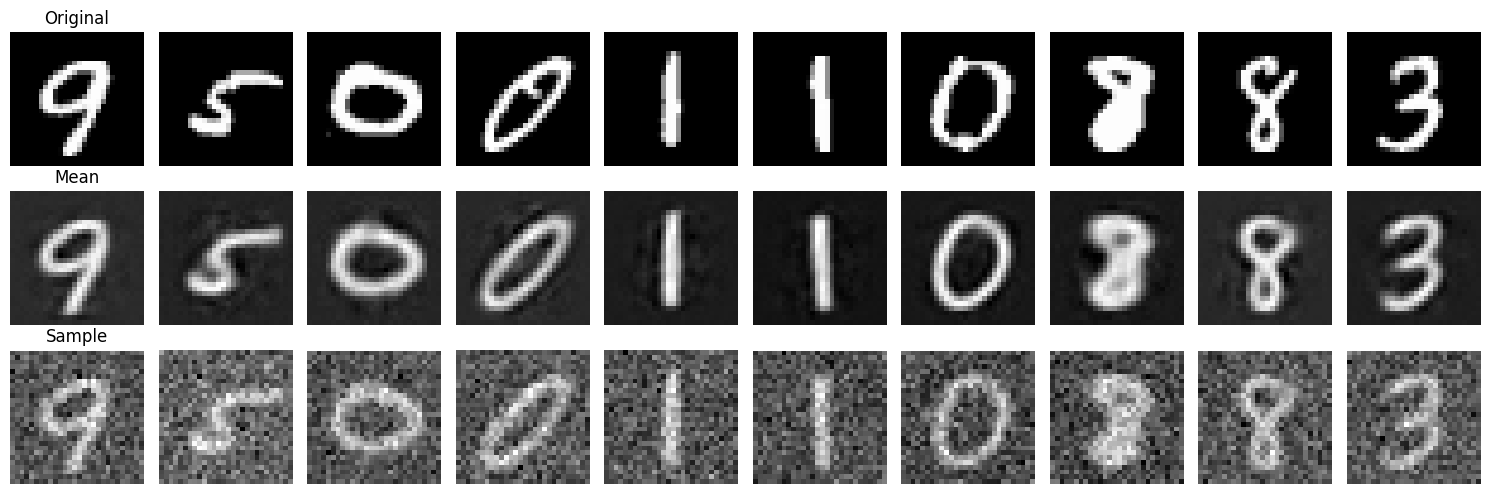

In [9]:
import matplotlib.pyplot as plt
import jax.random

batch, _ = next(iter(train_loader))
batch = batch.numpy()
batch = jnp.array(batch)

_, _, likelihood, aux = eval_step(warmup_state, batch, N_data=60000)

recon_means = likelihood.mean()  
recon_samples = likelihood.sample(seed=jax.random.PRNGKey(0))

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    # Original
    axes[0, i].imshow(batch[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Original")

    # Mean reconstruction
    axes[1, i].imshow(recon_means[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Mean")

    # Sampled reconstruction
    axes[2, i].imshow(recon_samples[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_title("Sample")

plt.tight_layout()
plt.show()

In [10]:
#Latent Assignments
all_latents_train = []

train_loader_inference = DataLoader(train_dataset, batch_size=128, shuffle=False)
true_labels_train = train_dataset.targets.numpy()

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()
    _, _, _, aux = eval_step(warmup_state, batch_np, N_data=len(train_loader_inference.dataset))
    z = aux['aux'].mean()
    all_latents_train.append(z)
    
all_latents_train_np = np.concatenate(all_latents_train, axis=0)

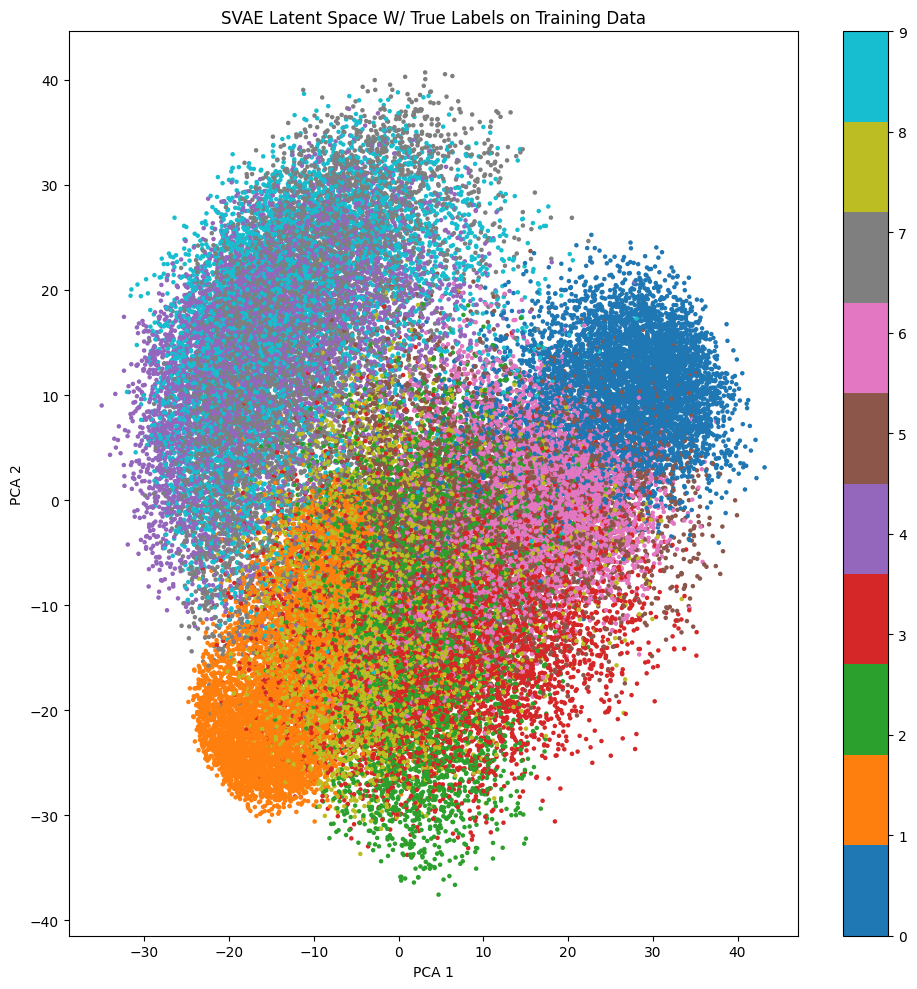

In [11]:
from sklearn.decomposition import PCA
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space W/ True Labels on Training Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [12]:
#Initializing full model with pretrained VAE parameters
new_params = state.params.copy()
new_params['encoder'] = warmup_state.params['encoder']
new_params['decoder'] = warmup_state.params['decoder']
state = state.replace(params=new_params)

In [13]:
import pandas as pd

df = pd.DataFrame(all_latents_train_np)
df.to_csv('latent_vectors.csv', index=False, header=False)

In [14]:
#Initializing Cluster Means With BNPY
import bnpy
from bnpy.data import GroupXData

X = np.loadtxt('latent_vectors.csv', delimiter=',')
N = X.shape[0]
Data = GroupXData(X=X, doc_range=np.array([0, N]))

hmodel, info_dict = bnpy.run(Data,
         'FiniteMixtureModel', 'Gauss', 'memoVB',
         K=20, nLap=1000, convergeThr=0.0001,
         output_path='initialization/')

Dataset Summary:
GroupXData
  total size: 1 units
  batch size: 1 units
  num. batches: 1
Allocation Model:  Finite mixture model. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.]  ...
  E[ covar[k] ] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 20 (number of clusters)
  seed = 1607680
  elapsed_time: 0.1 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: initialization/1
    1.000/1000 after      0 sec. |    591.3 MiB | K   20 | loss  3.815986714e+00 |  
    2.000/1000 after      0 sec. |    581.5 MiB | K   20 | loss  3.750125501e+00 | Ndiff  851.575 
    3.000/1000 after      1 sec. |    586.8 MiB | K   20 | loss  3.729806688e+00 | Ndiff  680.697 
    4.000/1000 after      1 sec. |    589.0 MiB | K   20 | loss  3.716414703e+00 | Ndiff  482.465 
    5.000/1000 after      1 sec. |    577.

In [15]:
import jax.numpy as jnp
from flax.core import freeze, unfreeze

means_fn = hmodel.obsModel.get_mean_for_comp
means_np = np.array([means_fn(k) for k in range(hmodel.obsModel.K)])

means_jax = jnp.array(means_np)[:, :, jnp.newaxis]

In [16]:
new_params = state.params.copy()
new_params['pgm']['loc'] = means_jax
state = state.replace(params=new_params)

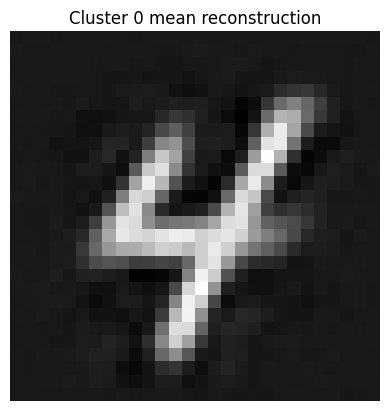

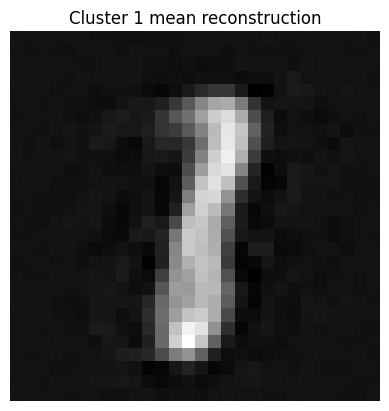

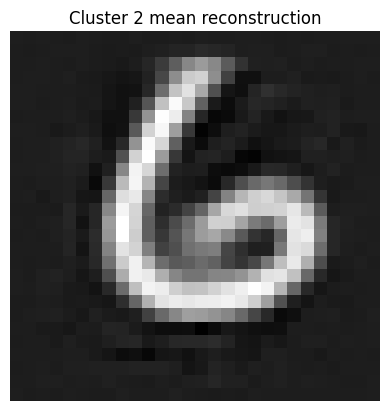

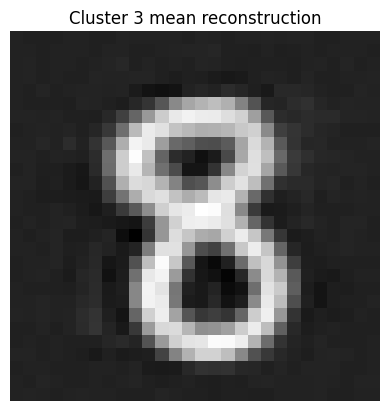

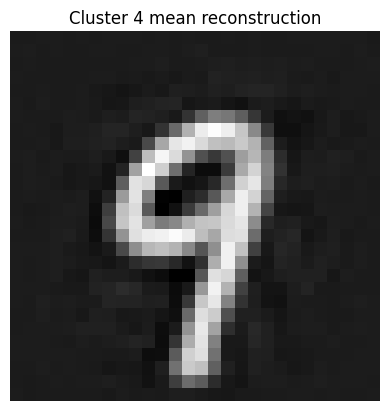

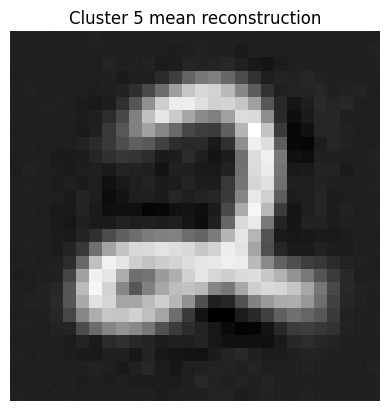

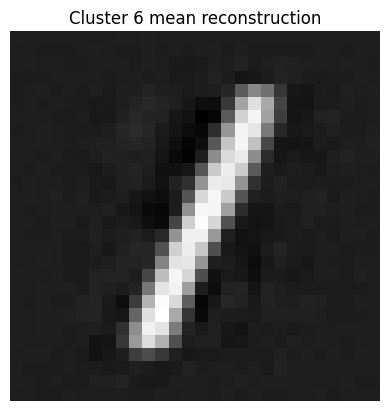

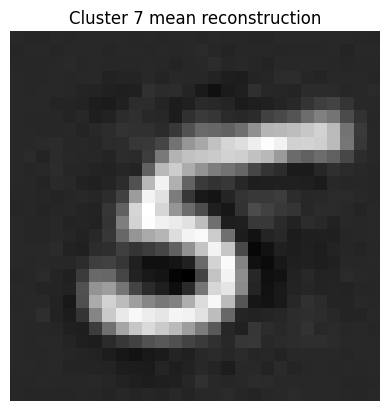

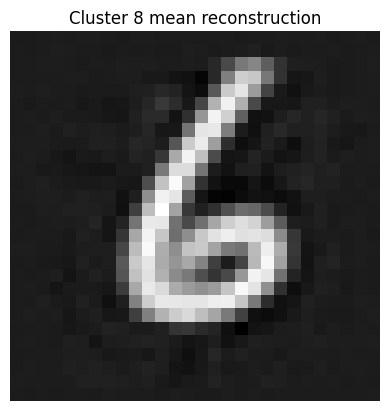

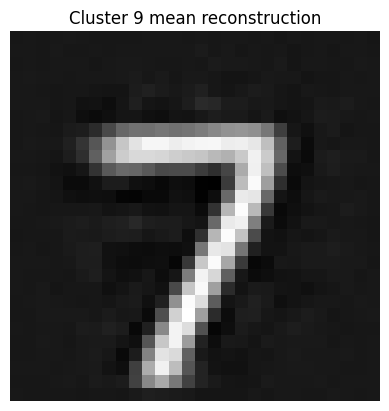

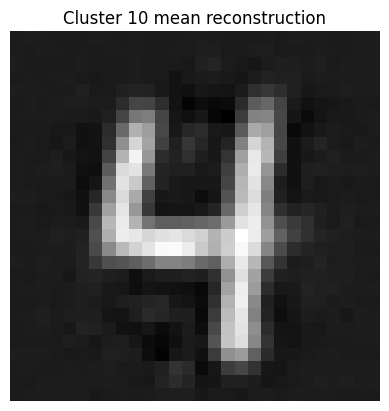

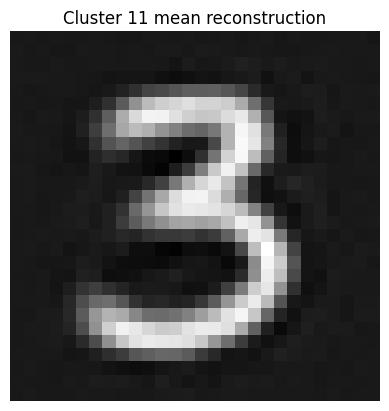

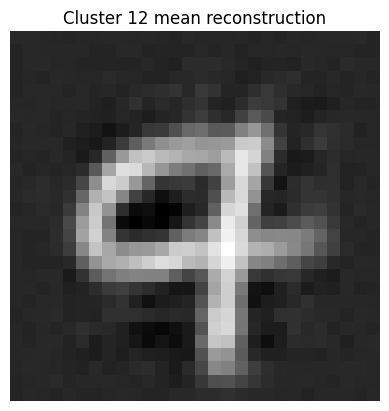

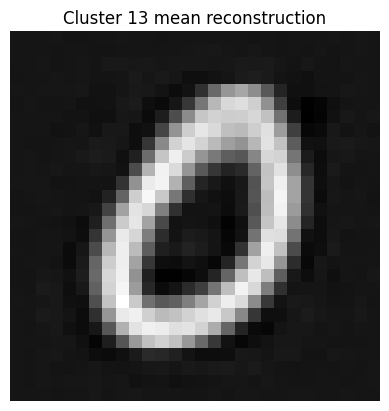

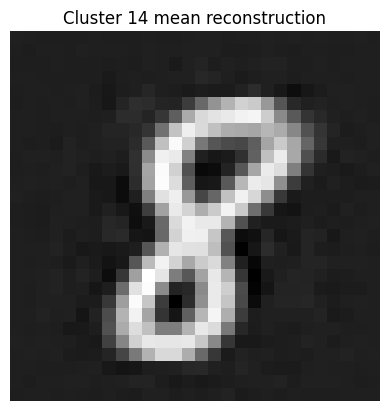

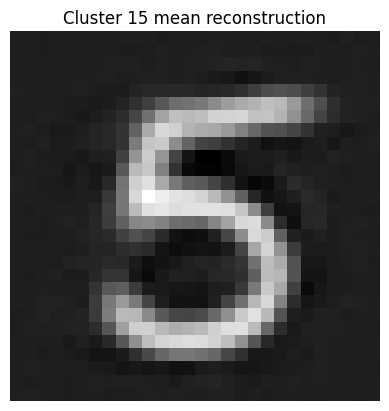

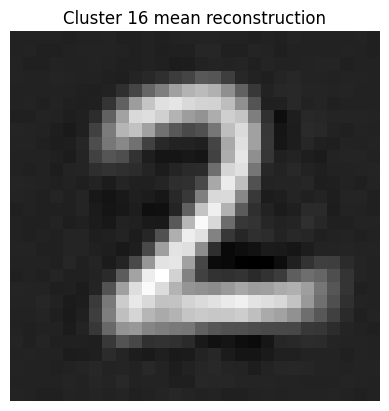

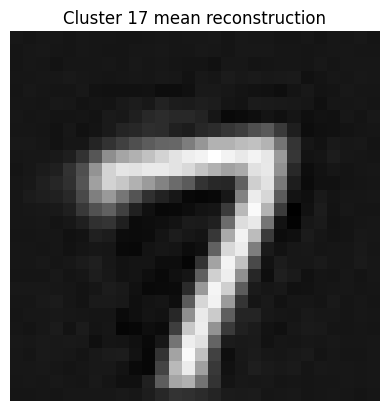

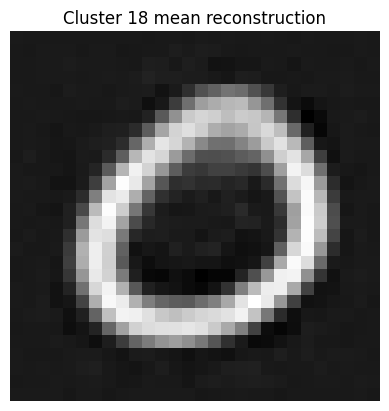

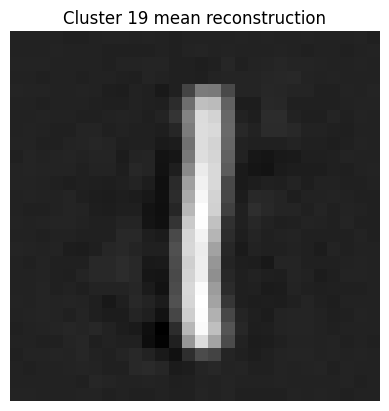

In [17]:
for k in range(20):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.mean()[0]
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} mean reconstruction')
    plt.show()

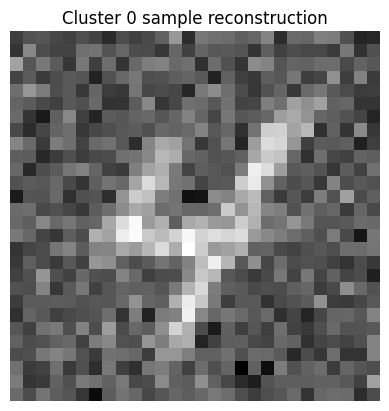

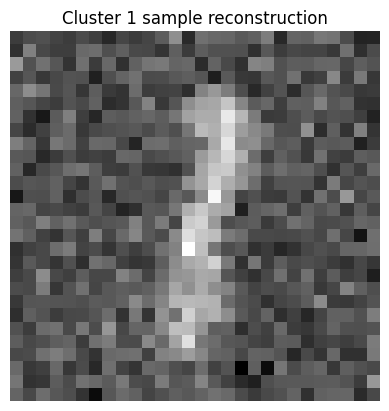

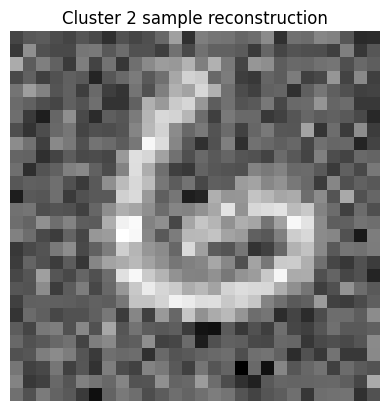

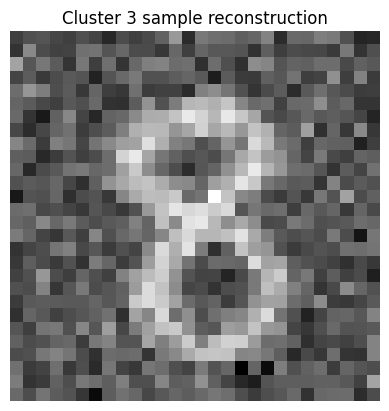

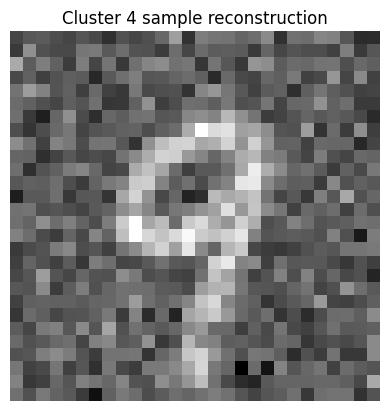

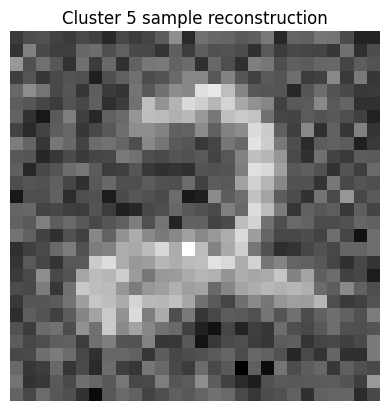

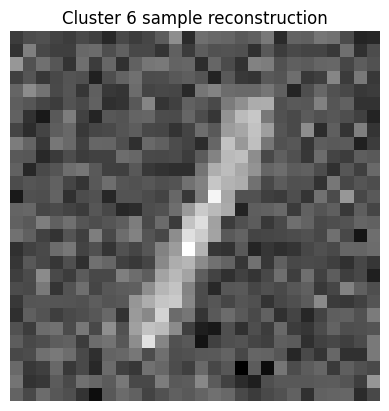

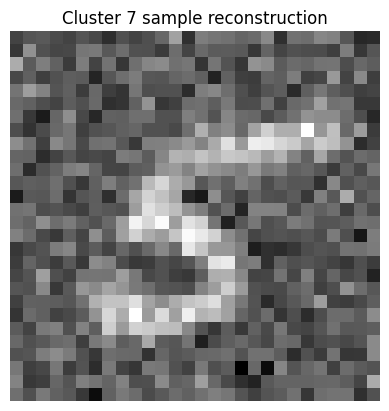

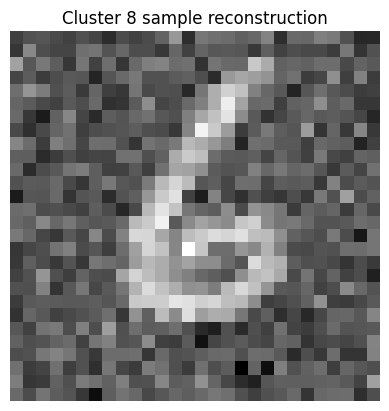

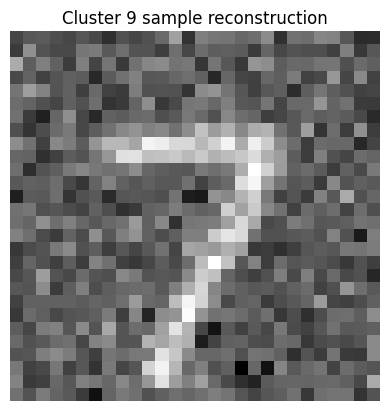

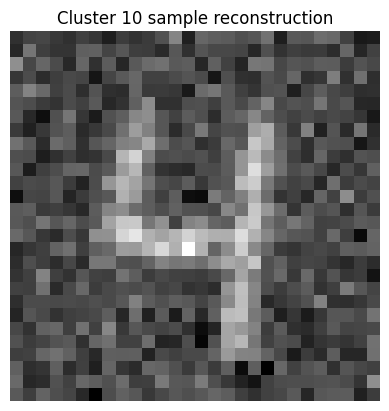

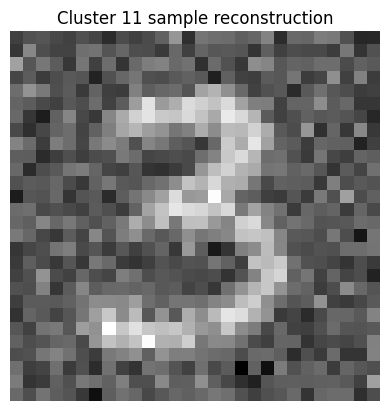

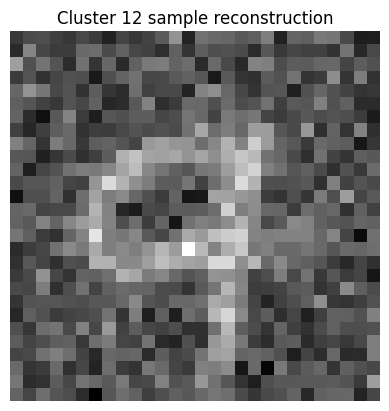

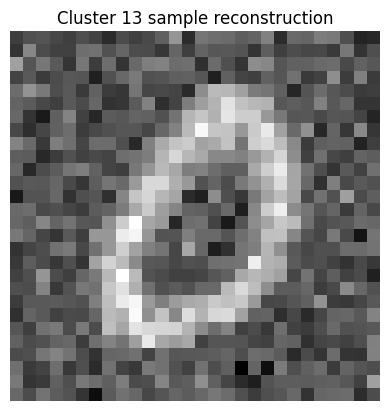

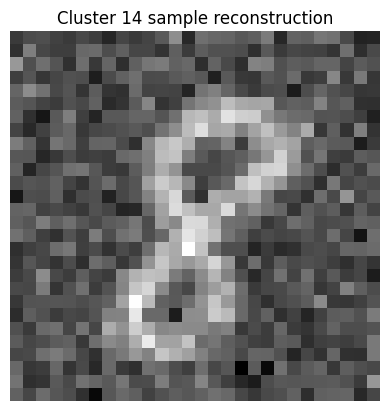

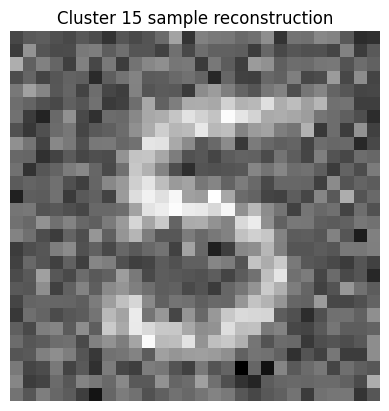

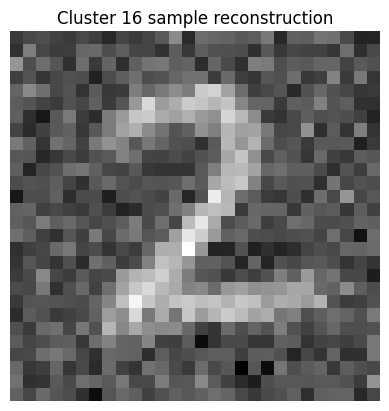

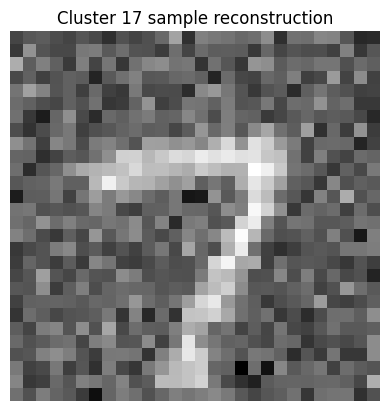

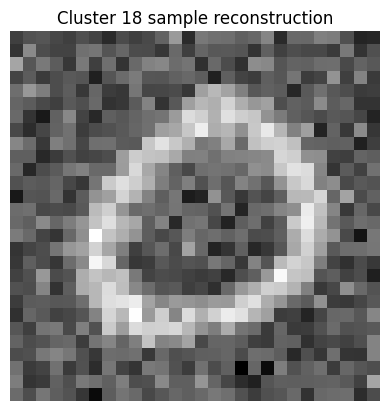

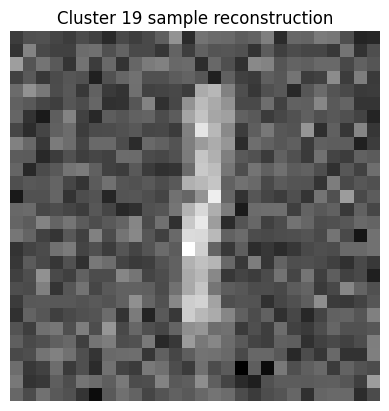

In [18]:
for k in range(20):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.sample(seed=jax.random.PRNGKey(47))
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} sample reconstruction')
    plt.show()

In [19]:
#Latent and cluster assignments
all_latents_train = []
all_clusters_train = []

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()

    _, _, _, aux = eval_step(state, batch_np, N_data=len(train_loader_inference.dataset))
    
    z = aux['aux'][0] 
    c = aux['aux'][1]

    all_latents_train.append(z)
    all_clusters_train.append(jnp.argmax(c, axis=1))
    
all_latents_train_np = jnp.concatenate(all_latents_train, axis=0)
all_clusters_train_np = jnp.concatenate(all_clusters_train, axis=0)

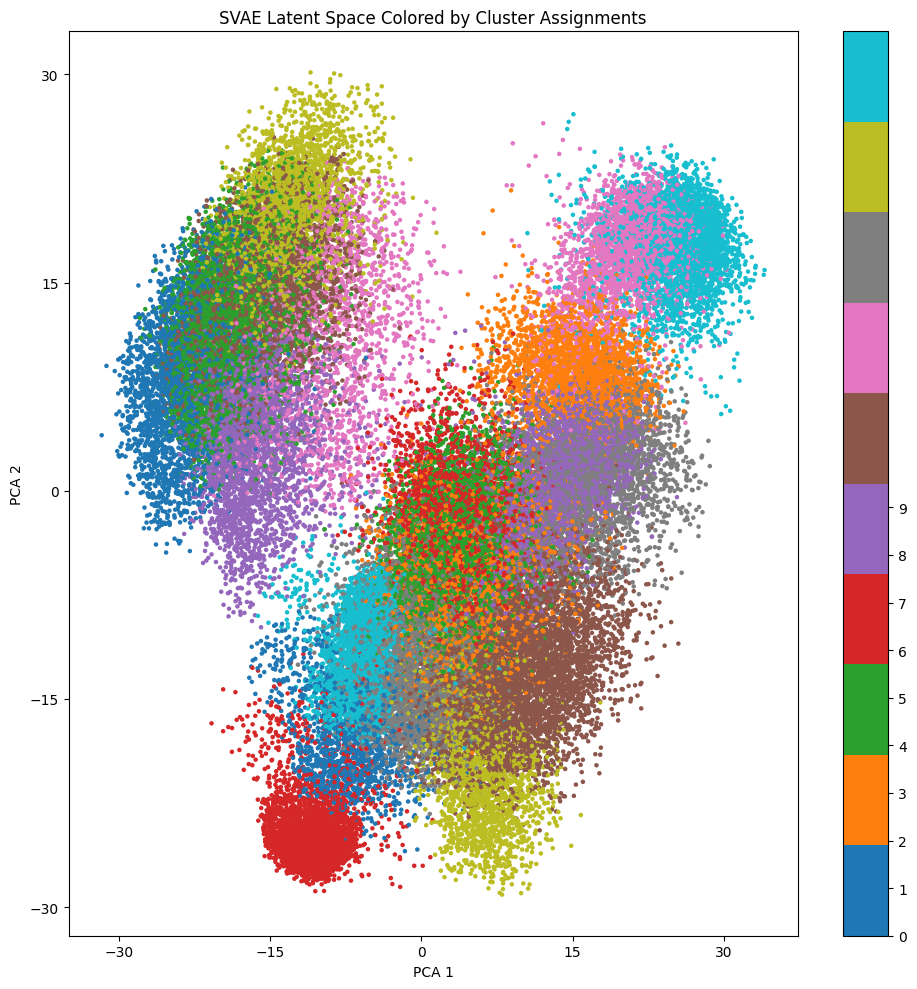

In [20]:
from sklearn.decomposition import PCA
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_clusters_train_np, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space Colored by Cluster Assignments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

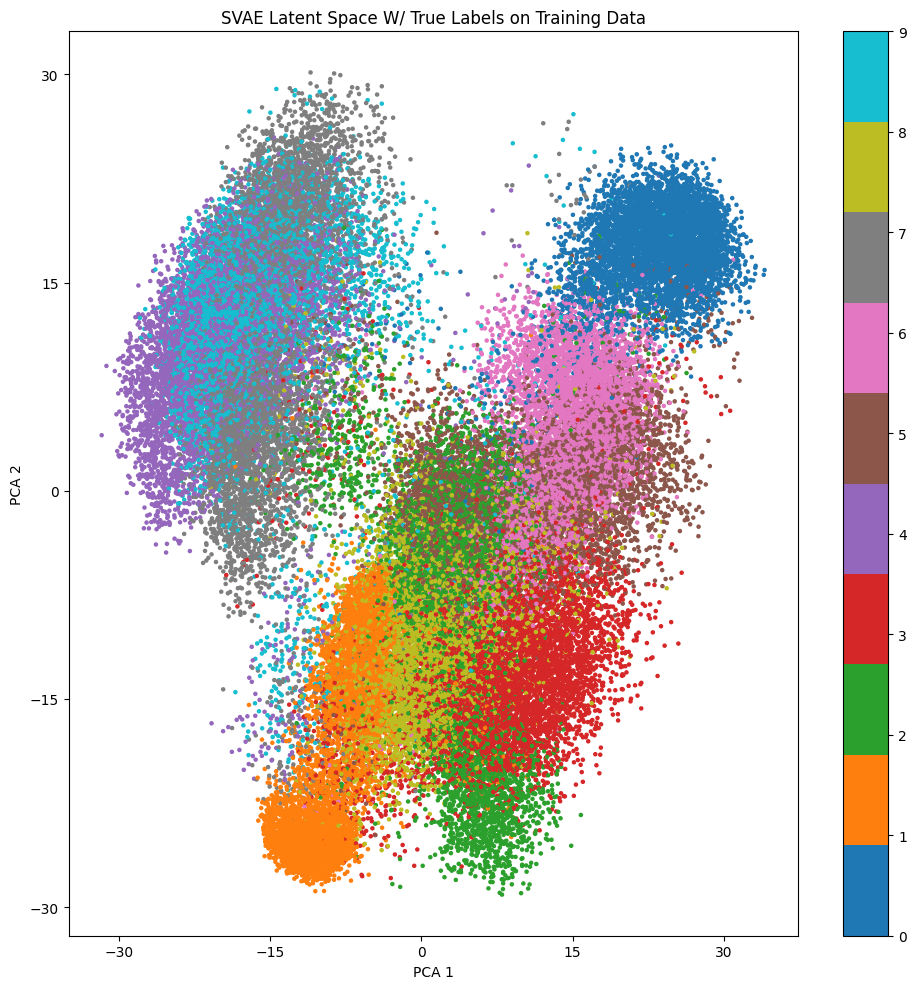

In [21]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space W/ True Labels on Training Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

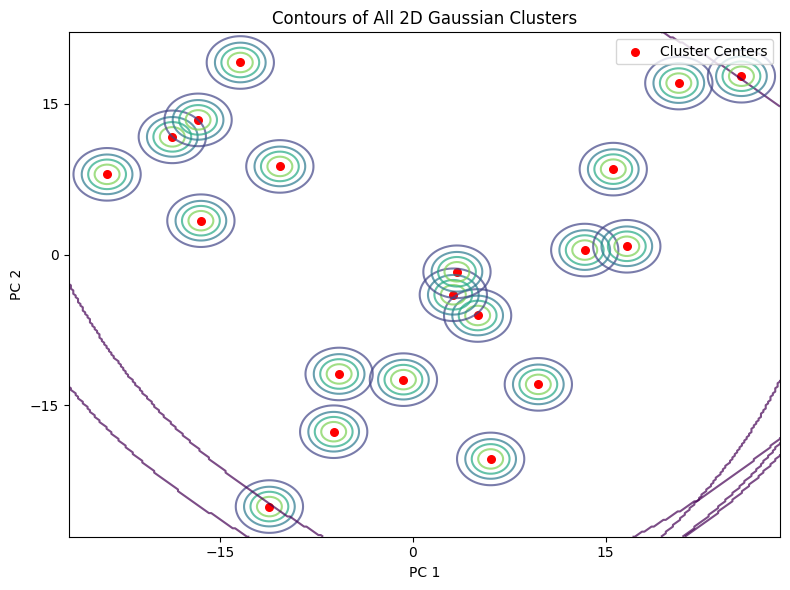

In [22]:
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Extract cluster parameters from your model
S = state.params['pgm']['S']         # shape: (K, D, D)
nu = state.params['pgm']['nu']       # shape: (K,)
loc = state.params['pgm']['loc']     # shape: (K, D)

# Convert from JAX to NumPy and squeeze
means = [np.array(loc[k]).squeeze() for k in range(len(loc))]
D = S.shape[-1]
covariances = [np.array(S[k]) for k in range(len(S))]

# Project to 2D using PCA (fit on means)
means_matrix = np.stack(means)  # shape: (K, D)
pca = PCA(n_components=2)
pca.fit(all_latents_train_np)
means_2d = pca.transform(means_matrix)

covariances_2d = []
P = pca.components_  # shape (2, 10)

for cov in covariances:
    cov_2d = P @ cov @ P.T  # shape (2, 2)
    covariances_2d.append(cov_2d)

covariances_2d = np.stack(covariances_2d)

# Combine all cluster means to find global plotting bounds
means_2d_array = np.array(means_2d)
x_min, x_max = means_2d_array[:, 0].min() - 3, means_2d_array[:, 0].max() + 3
y_min, y_max = means_2d_array[:, 1].min() - 3, means_2d_array[:, 1].max() + 3

# Shared grid
N = 300
x = np.linspace(x_min, x_max, N)
y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot all clusters
fig, ax = plt.subplots(figsize=(8, 6))

for mean, cov in zip(means_2d, covariances_2d):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, levels=5, alpha=0.7)  # optionally: colors='tab10(i)', cmap=...

# Optionally add mean points
ax.scatter(means_2d_array[:, 0], means_2d_array[:, 1], color='red', s=30, label='Cluster Centers')
ax.set_title("Contours of All 2D Gaussian Clusters")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
def many_to_one_accuracy(y_true, y_pred, K, C):
    """
    y_true: array of shape (N,), true class labels (0..C-1)
    y_pred: array of shape (N,), predicted cluster IDs (0..K-1)
    K: number of clusters
    C: number of classes
    """
    # Build contingency table
    M = np.zeros((K, C), dtype=int)
    for k, c in zip(y_pred, y_true):
        M[k, c] += 1

    # Map each cluster to the majority label
    cluster_to_label = M.argmax(axis=1)

    # Relabel predictions
    y_pred_mapped = cluster_to_label[y_pred]

    # Compute accuracy
    return (y_pred_mapped == y_true).mean(), M, cluster_to_label

# Example usage
K = 20   # clusters
C = 10   # digits
acc, contingency, mapping = many_to_one_accuracy(true_labels_train, all_clusters_train_np, K, C)

In [24]:
acc

0.8912666666666667

In [26]:
#Training
num_epochs = 100

losses = []
total_steps = 0


for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    epoch_losses = []

    for batch in pbar:
        total_steps += 1

        batch = batch[0]

        batch_np = batch.detach().cpu().numpy()

        state, metrics = train_step(state, batch_np, N_data=len(train_loader.dataset), local_kl_weight=0.5)

        epoch_losses.append(metrics['loss'])
        
        if np.isnan(metrics['loss'].item()):
            break
    
    loss = np.mean(epoch_losses)
    losses.append(loss)
    print(f"Epoch {epoch+1} | Epoch Loss: {loss:.4f}")

Epoch 1: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Epoch 1 | Epoch Loss: -144.3897


Epoch 2: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 2 | Epoch Loss: -213.7461


Epoch 3: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]


Epoch 3 | Epoch Loss: -248.9512


Epoch 4: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]


Epoch 4 | Epoch Loss: -278.0030


Epoch 5: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]


Epoch 5 | Epoch Loss: -304.0102


Epoch 6: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Epoch 6 | Epoch Loss: -327.8023


Epoch 7: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Epoch 7 | Epoch Loss: -350.6170


Epoch 8: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s]


Epoch 8 | Epoch Loss: -371.9725


Epoch 9: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Epoch 9 | Epoch Loss: -393.0567


Epoch 10: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]


Epoch 10 | Epoch Loss: -413.0421


Epoch 11: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Epoch 11 | Epoch Loss: -433.0765


Epoch 12: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]


Epoch 12 | Epoch Loss: -452.1373


Epoch 13: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


Epoch 13 | Epoch Loss: -471.0292


Epoch 14: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]


Epoch 14 | Epoch Loss: -489.5341


Epoch 15: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]


Epoch 15 | Epoch Loss: -507.3280


Epoch 16: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 16 | Epoch Loss: -525.1408


Epoch 17: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]


Epoch 17 | Epoch Loss: -542.6212


Epoch 18: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


Epoch 18 | Epoch Loss: -559.6873


Epoch 19: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 19 | Epoch Loss: -576.4728


Epoch 20: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Epoch 20 | Epoch Loss: -592.9991


Epoch 21: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]


Epoch 21 | Epoch Loss: -609.3294


Epoch 22: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 22 | Epoch Loss: -625.3545


Epoch 23: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


Epoch 23 | Epoch Loss: -641.4606


Epoch 24: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


Epoch 24 | Epoch Loss: -656.9909


Epoch 25: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Epoch 25 | Epoch Loss: -672.2388


Epoch 26: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]


Epoch 26 | Epoch Loss: -687.3062


Epoch 27: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]


Epoch 27 | Epoch Loss: -702.5872


Epoch 28: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 28 | Epoch Loss: -717.1976


Epoch 29: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]


Epoch 29 | Epoch Loss: -731.8504


Epoch 30: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]


Epoch 30 | Epoch Loss: -746.3126


Epoch 31: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


Epoch 31 | Epoch Loss: -760.1639


Epoch 32: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]


Epoch 32 | Epoch Loss: -774.1913


Epoch 33: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]


Epoch 33 | Epoch Loss: -787.7534


Epoch 34: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]


Epoch 34 | Epoch Loss: -801.3379


Epoch 35: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Epoch 35 | Epoch Loss: -814.7083


Epoch 36: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


Epoch 36 | Epoch Loss: -827.8815


Epoch 37: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]


Epoch 37 | Epoch Loss: -840.8613


Epoch 38: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]


Epoch 38 | Epoch Loss: -853.7056


Epoch 39: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 39 | Epoch Loss: -866.2773


Epoch 40: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Epoch 40 | Epoch Loss: -878.5274


Epoch 41: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Epoch 41 | Epoch Loss: -891.1579


Epoch 42: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Epoch 42 | Epoch Loss: -902.8851


Epoch 43: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Epoch 43 | Epoch Loss: -915.2847


Epoch 44: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Epoch 44 | Epoch Loss: -926.8771


Epoch 45: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]


Epoch 45 | Epoch Loss: -938.4594


Epoch 46: 100%|██████████| 469/469 [00:20<00:00, 22.33it/s]


Epoch 46 | Epoch Loss: -949.7833


Epoch 47: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Epoch 47 | Epoch Loss: -961.0811


Epoch 48: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Epoch 48 | Epoch Loss: -972.4725


Epoch 49: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]


Epoch 49 | Epoch Loss: -983.3644


Epoch 50: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]


Epoch 50 | Epoch Loss: -994.1953


Epoch 51: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Epoch 51 | Epoch Loss: -1005.1482


Epoch 52: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]


Epoch 52 | Epoch Loss: -1015.7160


Epoch 53: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Epoch 53 | Epoch Loss: -1026.3249


Epoch 54: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]


Epoch 54 | Epoch Loss: -1036.5964


Epoch 55: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Epoch 55 | Epoch Loss: -1046.5480


Epoch 56: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 56 | Epoch Loss: -1056.7607


Epoch 57: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]


Epoch 57 | Epoch Loss: -1066.8983


Epoch 58: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


Epoch 58 | Epoch Loss: -1076.6685


Epoch 59: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]


Epoch 59 | Epoch Loss: -1086.3073


Epoch 60: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Epoch 60 | Epoch Loss: -1096.0230


Epoch 61: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]


Epoch 61 | Epoch Loss: -1105.4993


Epoch 62: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]


Epoch 62 | Epoch Loss: -1115.0017


Epoch 63: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]


Epoch 63 | Epoch Loss: -1124.0119


Epoch 64: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


Epoch 64 | Epoch Loss: -1133.1762


Epoch 65: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


Epoch 65 | Epoch Loss: -1142.3411


Epoch 66: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


Epoch 66 | Epoch Loss: -1151.2270


Epoch 67: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 67 | Epoch Loss: -1159.8231


Epoch 68: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


Epoch 68 | Epoch Loss: -1168.9659


Epoch 69: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]


Epoch 69 | Epoch Loss: -1177.3221


Epoch 70: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]


Epoch 70 | Epoch Loss: -1185.7717


Epoch 71: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]


Epoch 71 | Epoch Loss: -1194.4671


Epoch 72: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]


Epoch 72 | Epoch Loss: -1202.9375


Epoch 73: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


Epoch 73 | Epoch Loss: -1211.2680


Epoch 74: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Epoch 74 | Epoch Loss: -1219.4636


Epoch 75: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Epoch 75 | Epoch Loss: -1227.1836


Epoch 76: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


Epoch 76 | Epoch Loss: -1235.1951


Epoch 77: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]


Epoch 77 | Epoch Loss: -1242.7789


Epoch 78: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


Epoch 78 | Epoch Loss: -1250.7228


Epoch 79: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]


Epoch 79 | Epoch Loss: -1258.5240


Epoch 80: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]


Epoch 80 | Epoch Loss: -1265.4396


Epoch 81: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


Epoch 81 | Epoch Loss: -1273.6711


Epoch 82: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]


Epoch 82 | Epoch Loss: -1281.1461


Epoch 83: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch 83 | Epoch Loss: -1288.2038


Epoch 84: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Epoch 84 | Epoch Loss: -1295.9827


Epoch 85: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]


Epoch 85 | Epoch Loss: -1303.3230


Epoch 86: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Epoch 86 | Epoch Loss: -1310.1753


Epoch 87: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]


Epoch 87 | Epoch Loss: -1317.3636


Epoch 88: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


Epoch 88 | Epoch Loss: -1324.1974


Epoch 89: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]


Epoch 89 | Epoch Loss: -1331.1864


Epoch 90: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 90 | Epoch Loss: -1338.2187


Epoch 91: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]


Epoch 91 | Epoch Loss: -1344.7251


Epoch 92: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Epoch 92 | Epoch Loss: -1352.0552


Epoch 93: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]


Epoch 93 | Epoch Loss: -1351.2333


Epoch 94: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


Epoch 94 | Epoch Loss: -1364.2380


Epoch 95: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


Epoch 95 | Epoch Loss: -1371.9591


Epoch 96: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Epoch 96 | Epoch Loss: -1377.9746


Epoch 97: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


Epoch 97 | Epoch Loss: -1383.9638


Epoch 98: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


Epoch 98 | Epoch Loss: -1391.3200


Epoch 99: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Epoch 99 | Epoch Loss: -1397.3310


Epoch 100: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]


Epoch 100 | Epoch Loss: -1403.3568


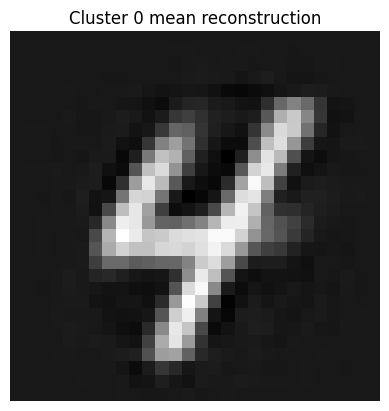

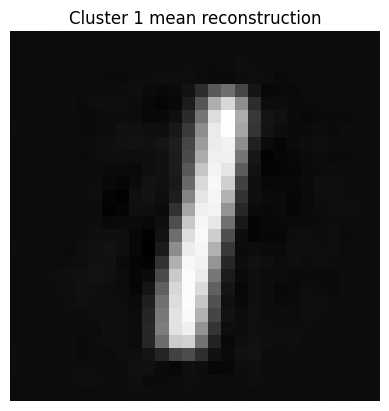

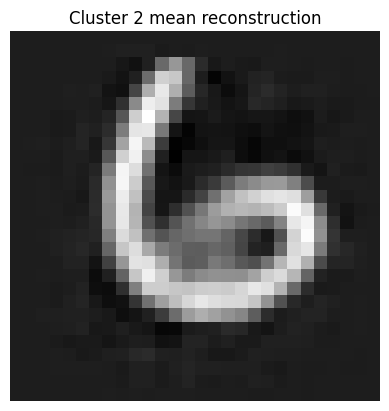

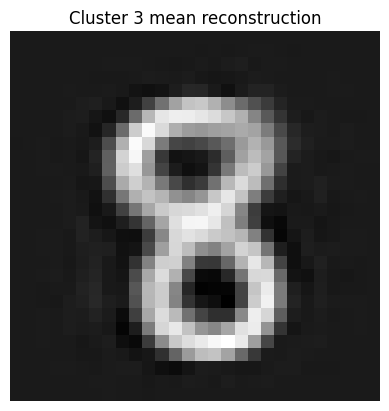

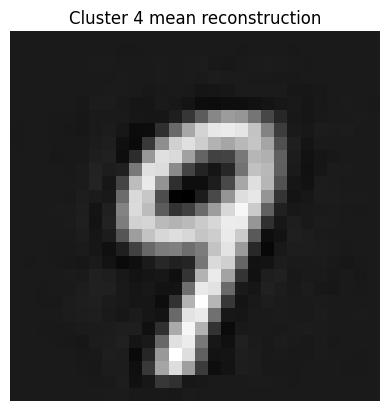

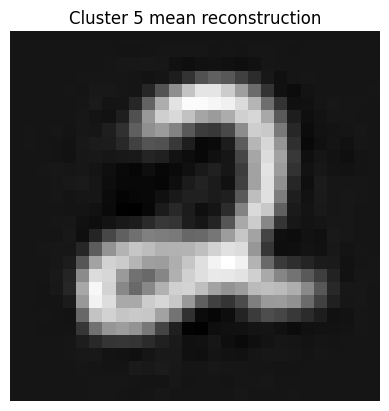

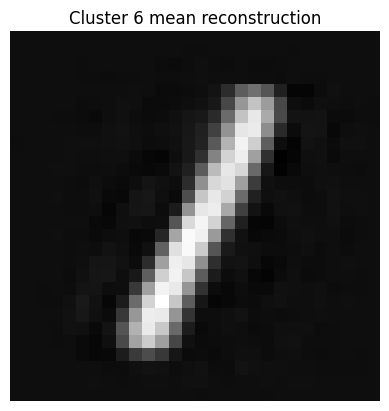

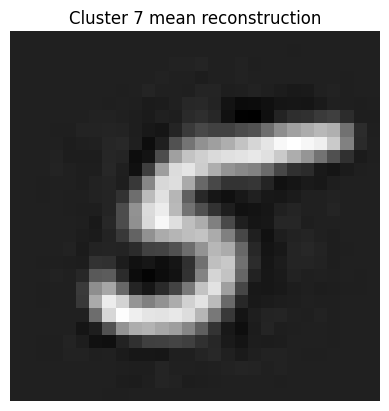

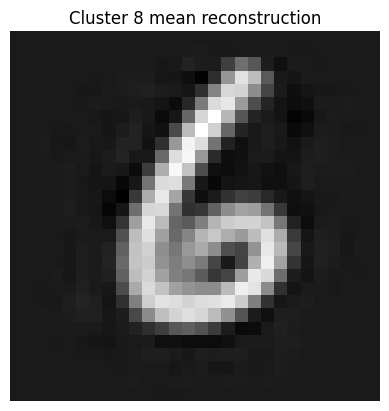

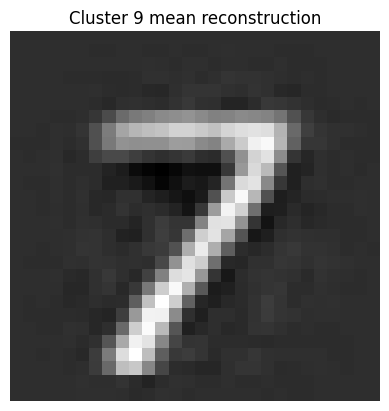

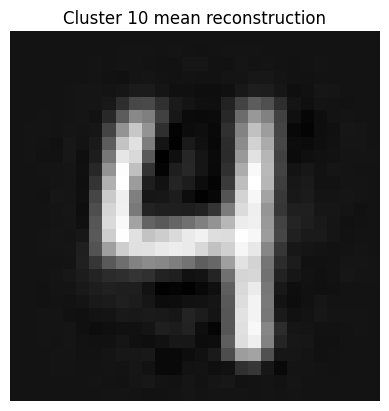

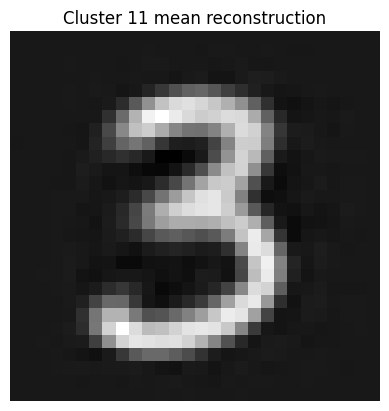

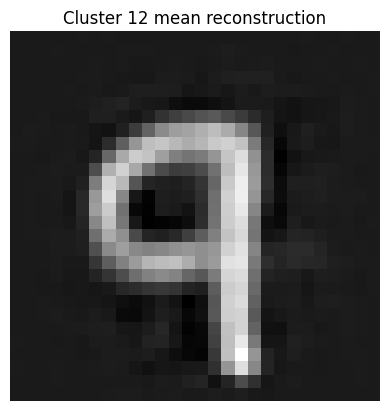

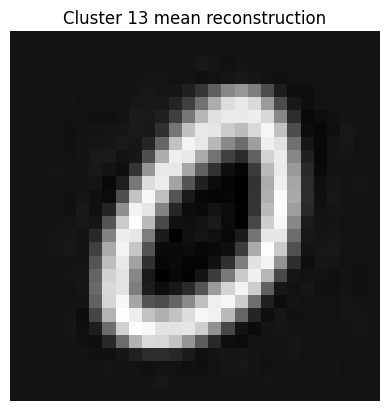

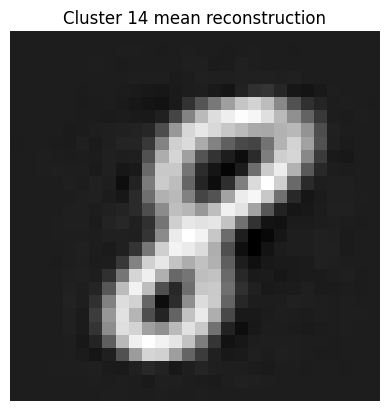

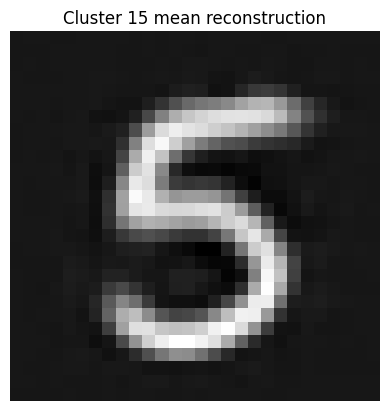

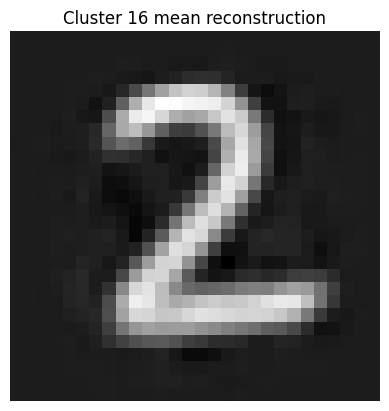

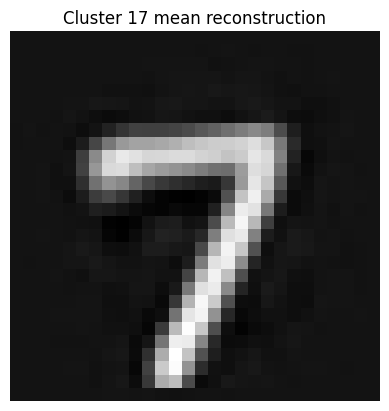

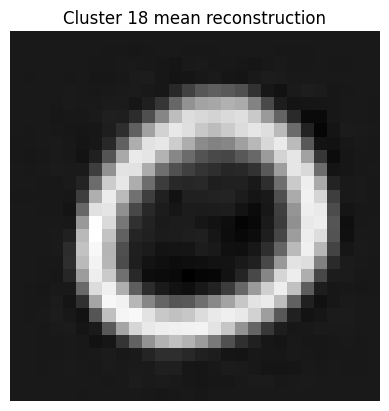

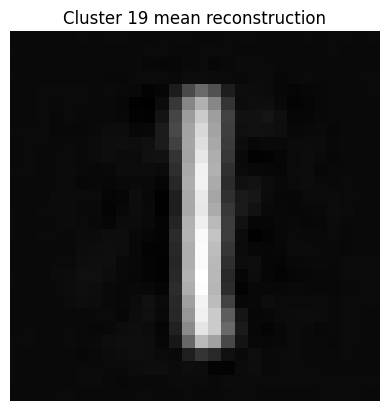

In [27]:
for k in range(20):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.mean()[0]
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} mean reconstruction')
    plt.show()

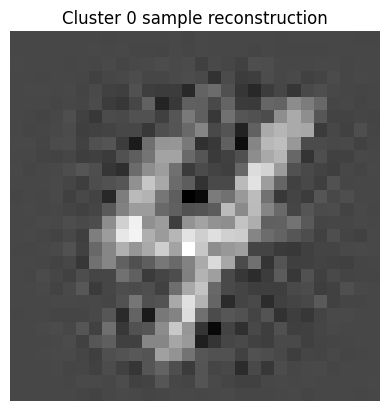

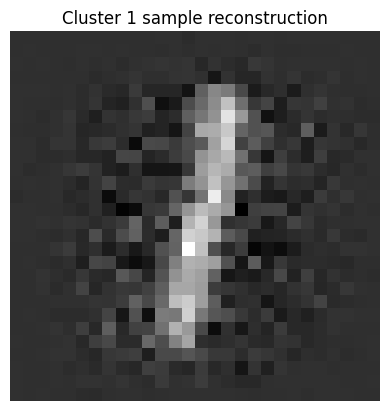

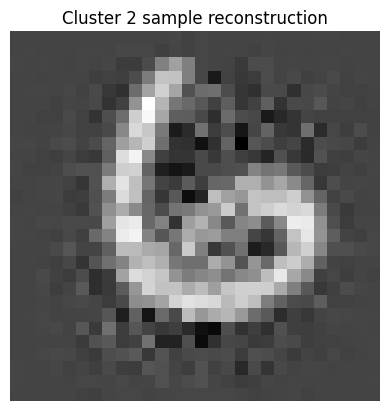

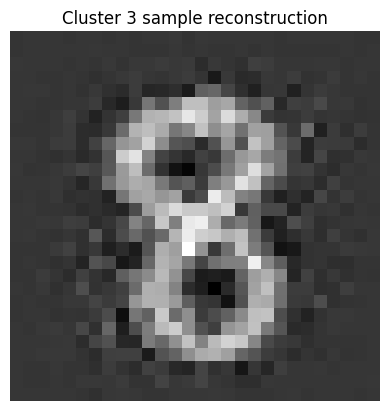

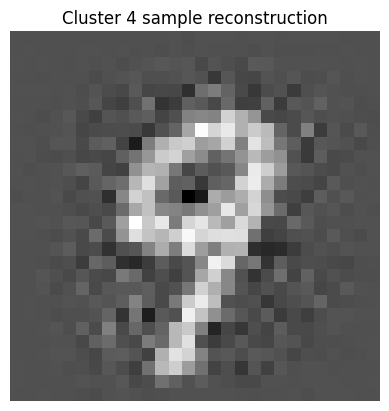

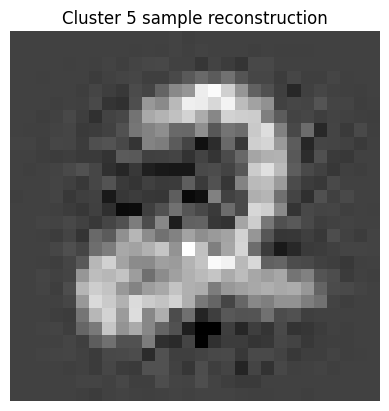

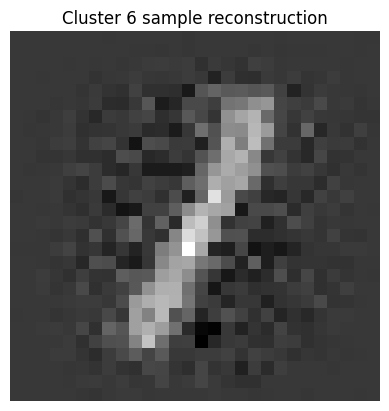

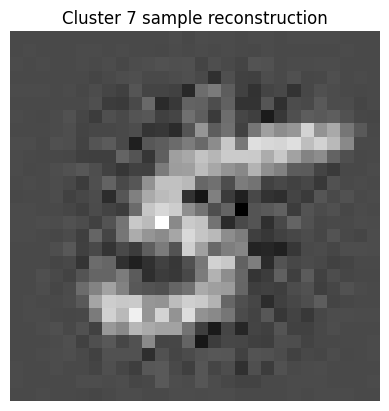

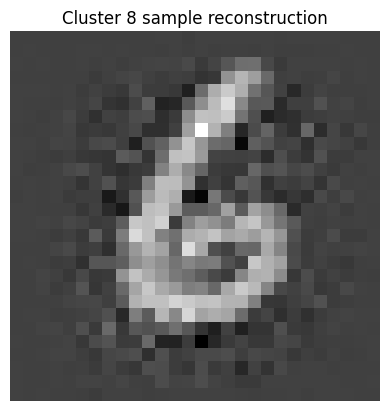

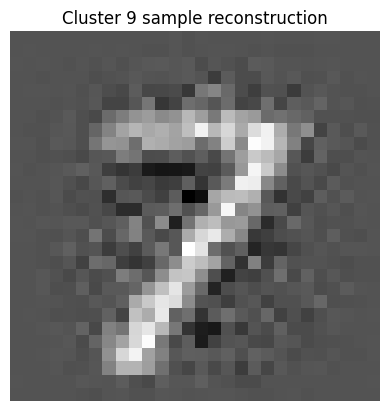

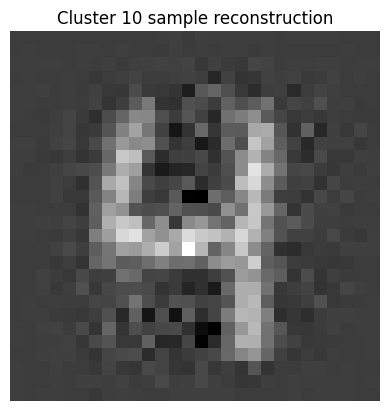

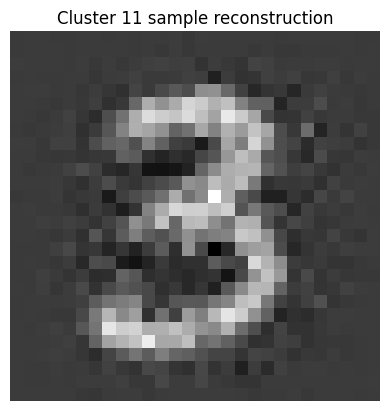

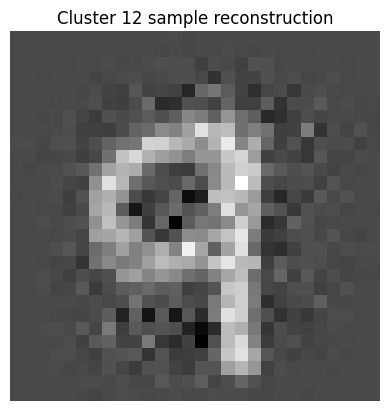

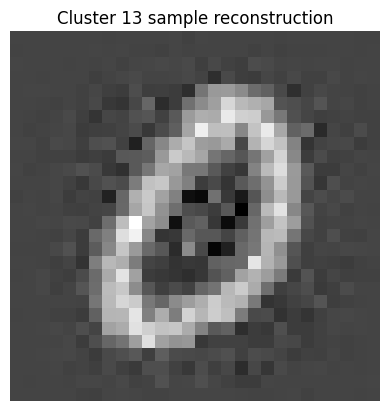

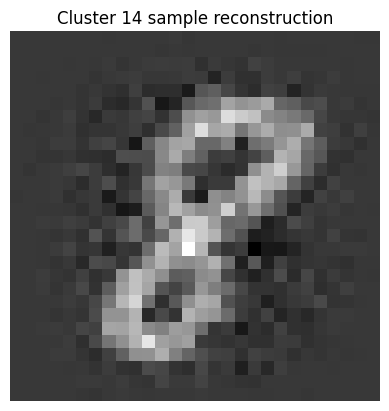

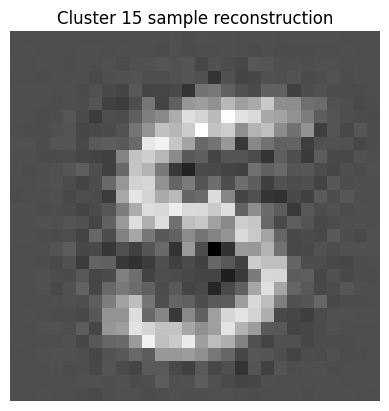

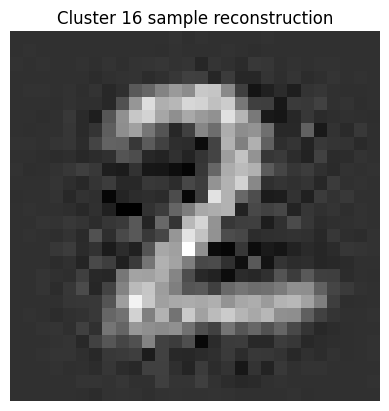

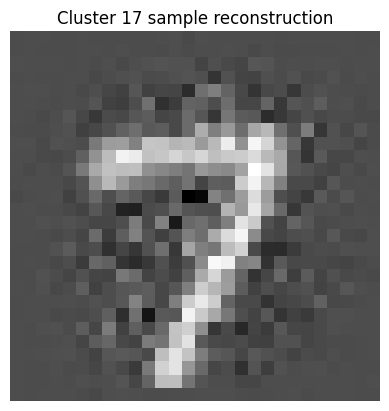

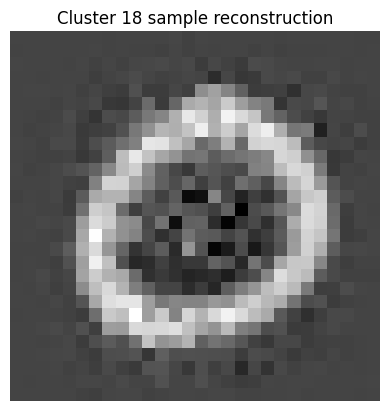

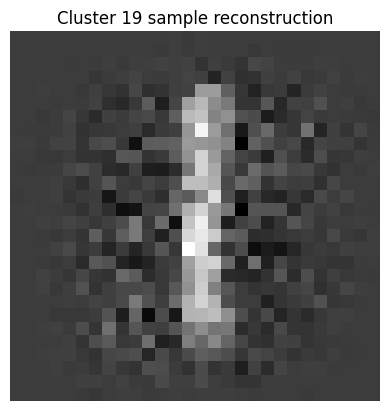

In [28]:
for k in range(20):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.sample(seed=jax.random.PRNGKey(47))
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} sample reconstruction')
    plt.show()

In [29]:
#Latent and cluster assignments
all_latents_train = []
all_clusters_train = []

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()

    _, _, _, aux = eval_step(state, batch_np, N_data=len(train_loader_inference.dataset))
    
    z = aux['aux'][0] 
    c = aux['aux'][1]

    all_latents_train.append(z)
    all_clusters_train.append(jnp.argmax(c, axis=1))
    
all_latents_train_np = jnp.concatenate(all_latents_train, axis=0)
all_clusters_train_np = jnp.concatenate(all_clusters_train, axis=0)

In [30]:
acc2, contingency2, mapping2 = many_to_one_accuracy(true_labels_train, all_clusters_train_np, K, C)
acc2

0.9239666666666667

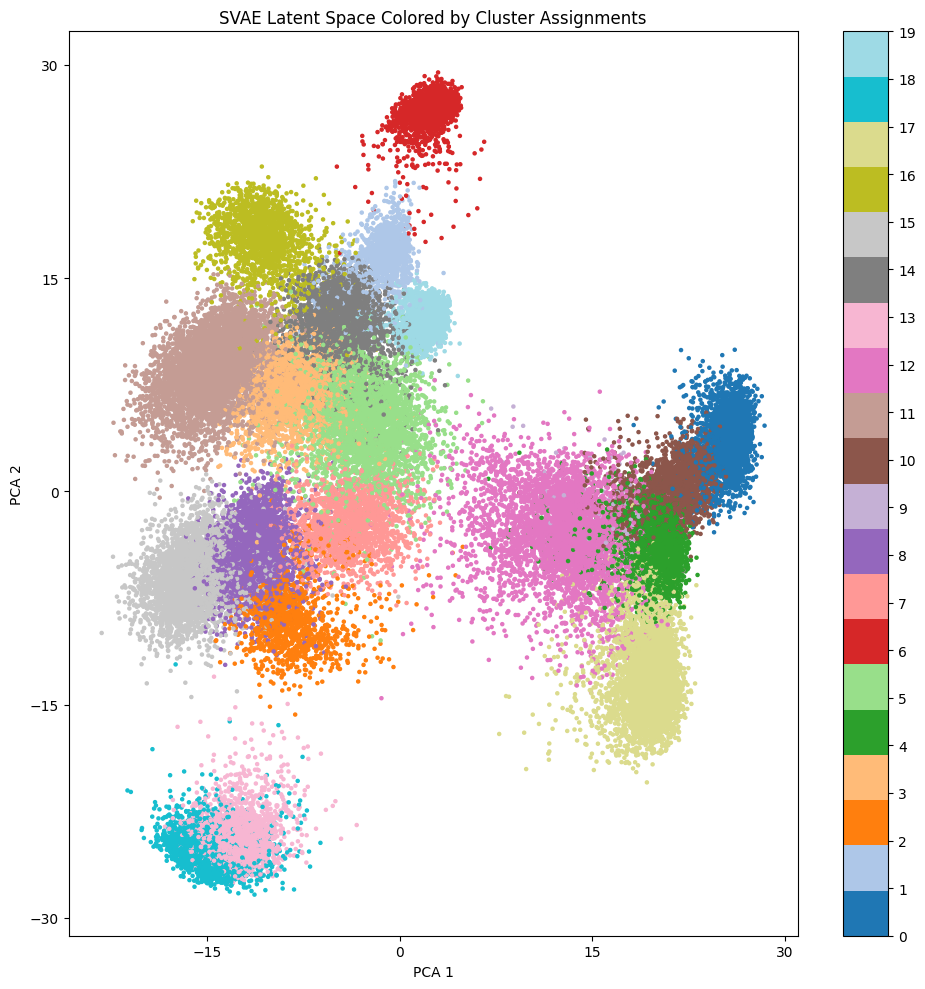

In [33]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_clusters_train_np, cmap='tab20', s=5)
plt.colorbar(scatter, ticks=range(20))
plt.title("SVAE Latent Space Colored by Cluster Assignments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

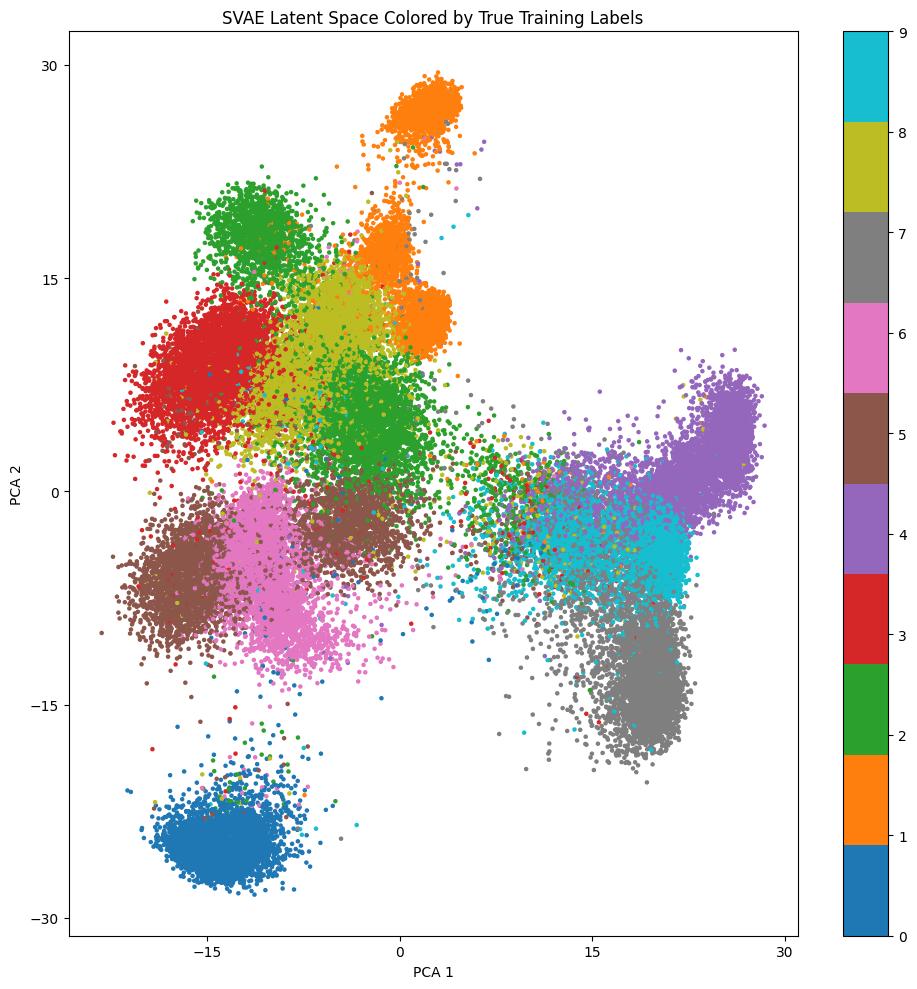

In [35]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space Colored by True Training Labels")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

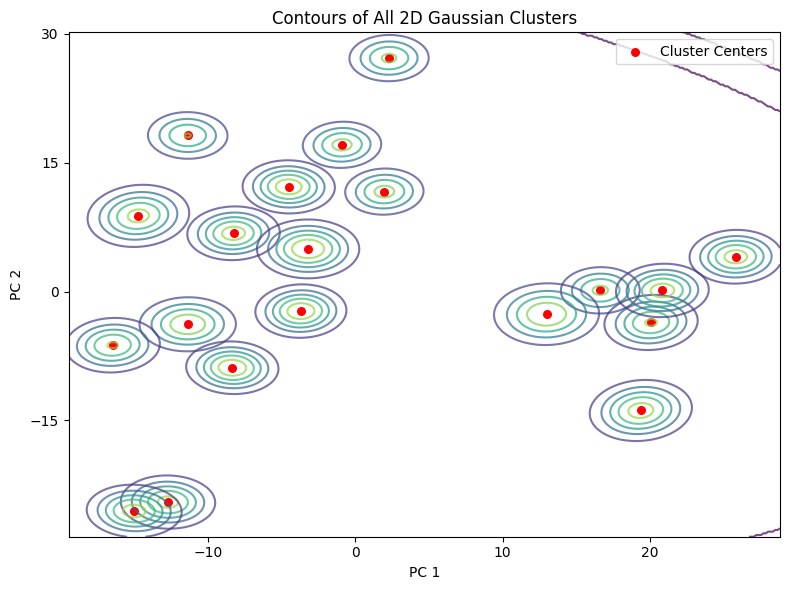

In [39]:
# Extract cluster parameters from your model
S = state.params['pgm']['S']         # shape: (K, D, D)
nu = state.params['pgm']['nu']       # shape: (K,)
loc = state.params['pgm']['loc']     # shape: (K, D)

# Convert from JAX to NumPy and squeeze
means = [np.array(loc[k]).squeeze() for k in range(len(loc))]
D = S.shape[-1]
covariances = [np.array(S[k]) for k in range(len(S))]

# Project to 2D using PCA (fit on means)
means_matrix = np.stack(means)  # shape: (K, D)
pca = PCA(n_components=2)
pca.fit(all_latents_train_np)
means_2d = pca.transform(means_matrix)

covariances_2d = []
P = pca.components_  # shape (2, 10)

for cov in covariances:
    cov_2d = P @ cov @ P.T  # shape (2, 2)
    covariances_2d.append(cov_2d)

covariances_2d = np.stack(covariances_2d)

# Combine all cluster means to find global plotting bounds
means_2d_array = np.array(means_2d)
x_min, x_max = means_2d_array[:, 0].min() - 3, means_2d_array[:, 0].max() + 3
y_min, y_max = means_2d_array[:, 1].min() - 3, means_2d_array[:, 1].max() + 3

# Shared grid
N = 300
x = np.linspace(x_min, x_max, N)
y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot all clusters
fig, ax = plt.subplots(figsize=(8, 6))

for mean, cov in zip(means_2d, covariances_2d):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, levels=5, alpha=0.7)  # optionally: colors='tab10(i)', cmap=...

# Optionally add mean points
ax.scatter(means_2d_array[:, 0], means_2d_array[:, 1], color='red', s=30, label='Cluster Centers')
ax.set_title("Contours of All 2D Gaussian Clusters")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend()
plt.tight_layout()
plt.show()

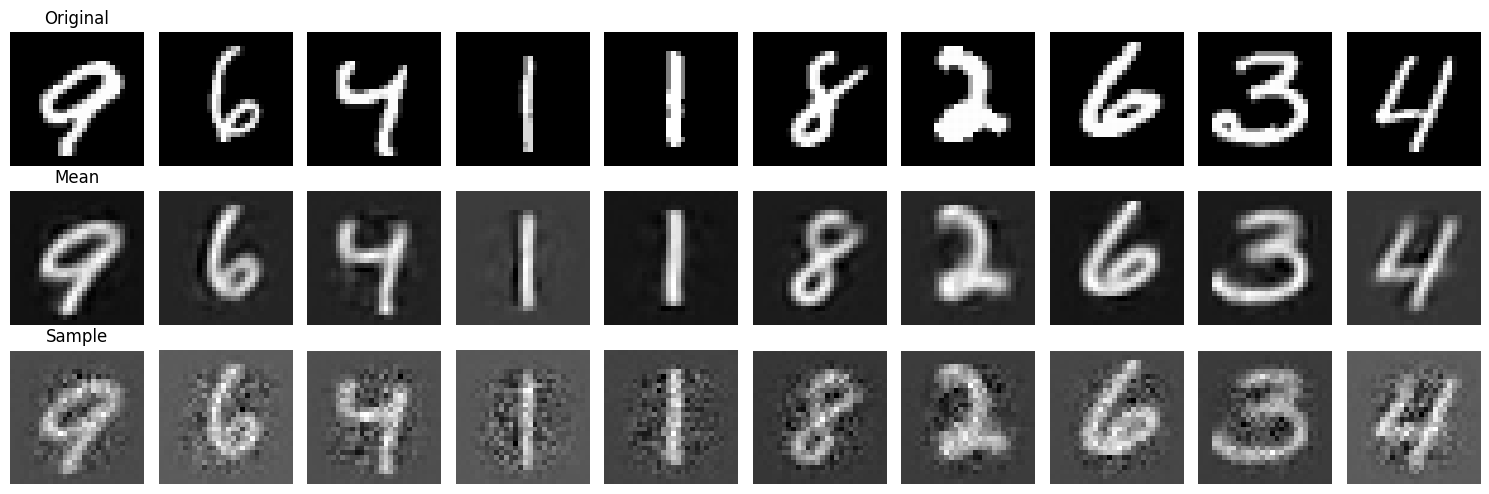

In [40]:
batch, _ = next(iter(train_loader))
batch = batch.numpy()
batch = jnp.array(batch)

_, _, likelihood, aux = eval_step(state, batch, N_data=60000)

recon_means = likelihood.mean()  
recon_samples = likelihood.sample(seed=jax.random.PRNGKey(0))

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    # Original
    axes[0, i].imshow(batch[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Original")

    # Mean reconstruction
    axes[1, i].imshow(recon_means[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Mean")

    # Sampled reconstruction
    axes[2, i].imshow(recon_samples[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_title("Sample")

plt.tight_layout()
plt.show()